<a href="https://www.kaggle.com/code/jameelsawafta/diabetic-retinopathy-using-vgg16-custom-model?scriptVersionId=184213205" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import vgg16
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

In [2]:
data_dir = '/kaggle/input/eyepacs-aptos-messidor-diabetic-retinopathy/augmented_resized_V2'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

In [3]:
print(torch.cuda.is_available()) 

True


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
def count_images(directory):
    categories = ['0', '1', '2', '3', '4']
    counts = {category: len(os.listdir(os.path.join(directory, category))) for category in categories}
    return counts

# Count images
train_counts = count_images(train_dir)
val_counts = count_images(val_dir)
test_counts = count_images(test_dir)


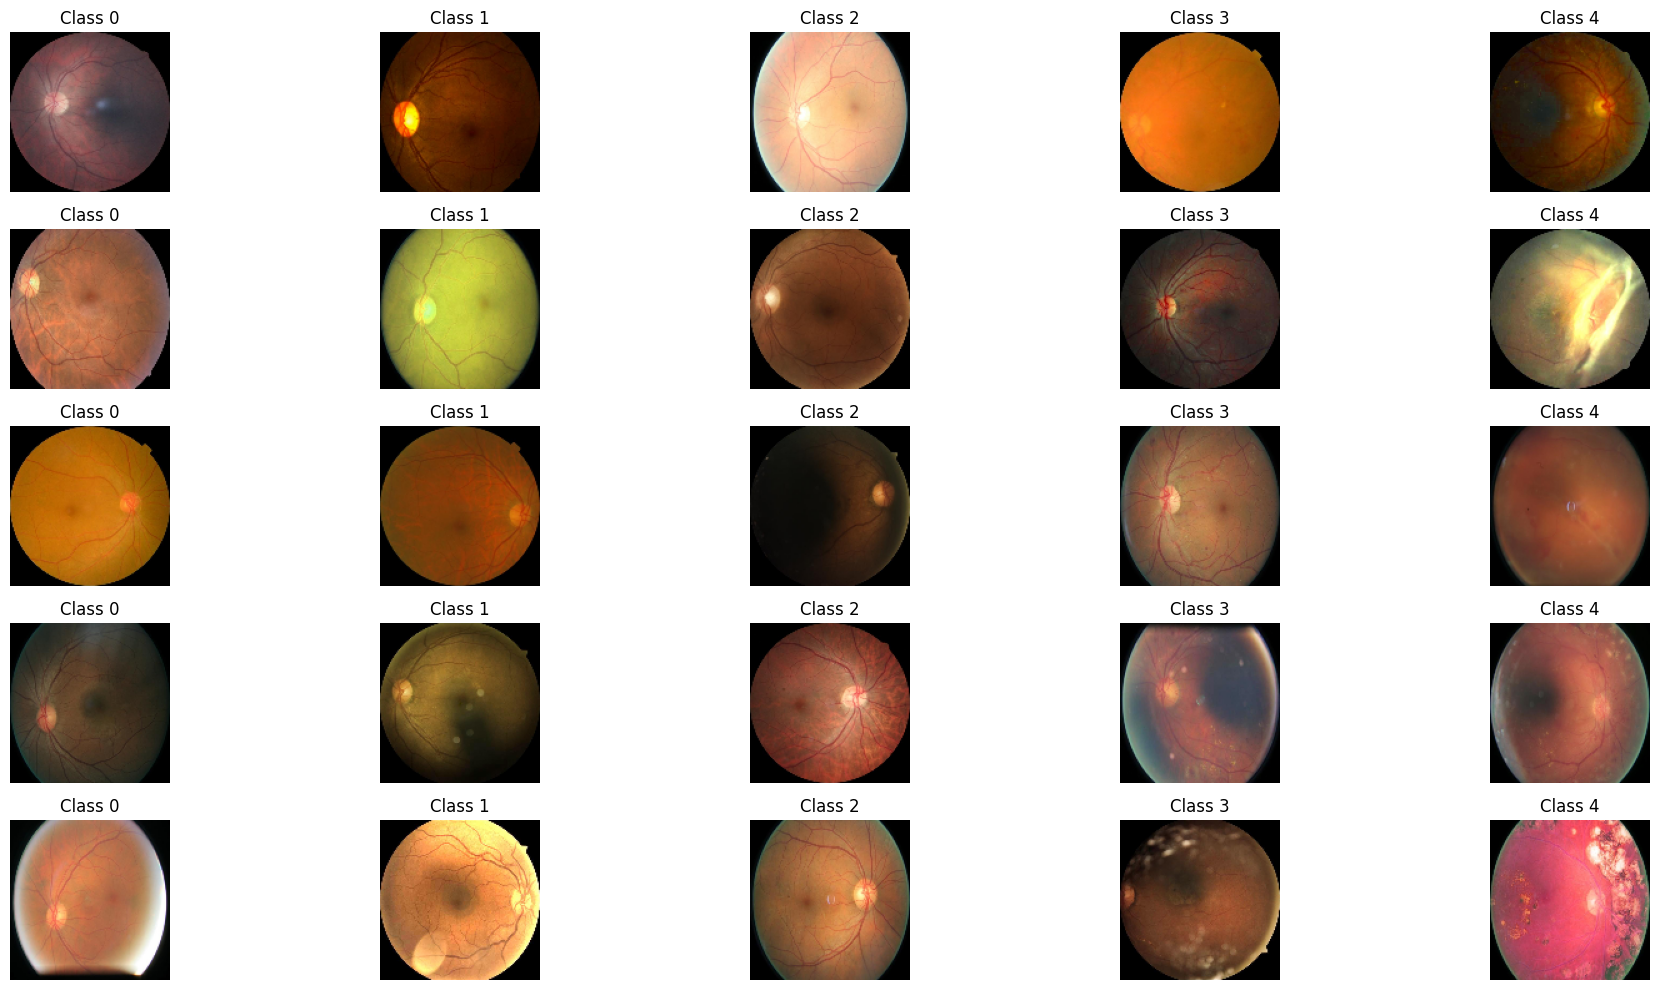

In [6]:
def plot_sample_images(directory, categories, img_size=(128, 128), samples_per_category=5):
    plt.figure(figsize=(20, 10))
    for i, category in enumerate(categories):
        img_dir = os.path.join(directory, category)
        img_files = os.listdir(img_dir)[:samples_per_category]
        for j, img_file in enumerate(img_files):
            img_path = os.path.join(img_dir, img_file)
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, img_size)
            plt.subplot(samples_per_category, len(categories), i + 1 + j * len(categories))
            plt.imshow(img)
            plt.title(f'Class {category}')
            plt.axis('off')
    plt.tight_layout()
    plt.show()

categories = ['0', '1', '2', '3', '4']
plot_sample_images(train_dir, categories)


In [7]:
img_size = (224, 224)
batch_size = 32

train_transform = transforms.Compose([
    transforms.RandomRotation(20),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load datasets using ImageFolder
train_dataset = ImageFolder(train_dir, transform=train_transform)
val_dataset = ImageFolder(val_dir, transform=val_transform)
test_dataset = ImageFolder(test_dir, transform=val_transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [8]:
class CustomVGG16(nn.Module):
    def __init__(self):
        super(CustomVGG16, self).__init__()
        self.features = vgg16(pretrained=True).features
        self.classifier = nn.Sequential(
            nn.Linear(25088, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 5)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = CustomVGG16().to(device)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 166MB/s]  


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [11]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for i, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        if (i + 1) % 10 == 0:  # Print every 10 batches
            print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{i+1}/{len(train_loader)}], '
                  f'Train Loss: {loss.item():.4f}, Train Acc: {(predicted == labels).sum().item() / labels.size(0):.4f}')

    epoch_train_loss = running_loss / len(train_loader.dataset)
    epoch_train_acc = correct_train / total_train

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    epoch_val_loss = val_loss / len(val_loader.dataset)
    epoch_val_acc = correct_val / total_val

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.4f}, '
          f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.4f}')

# Evaluation
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_accuracy = correct / total
print(f'Test Accuracy: {test_accuracy:.4f}')


Epoch [1/10], Batch [10/3602], Train Loss: 1.4613, Train Acc: 0.4688
Epoch [1/10], Batch [20/3602], Train Loss: 1.0525, Train Acc: 0.6250
Epoch [1/10], Batch [30/3602], Train Loss: 1.4244, Train Acc: 0.3750
Epoch [1/10], Batch [40/3602], Train Loss: 1.1891, Train Acc: 0.5312
Epoch [1/10], Batch [50/3602], Train Loss: 1.1464, Train Acc: 0.5312
Epoch [1/10], Batch [60/3602], Train Loss: 1.0842, Train Acc: 0.6250
Epoch [1/10], Batch [70/3602], Train Loss: 1.2884, Train Acc: 0.4375
Epoch [1/10], Batch [80/3602], Train Loss: 1.3092, Train Acc: 0.5000
Epoch [1/10], Batch [90/3602], Train Loss: 1.2546, Train Acc: 0.4062
Epoch [1/10], Batch [100/3602], Train Loss: 1.0454, Train Acc: 0.6250
Epoch [1/10], Batch [110/3602], Train Loss: 1.0872, Train Acc: 0.5625
Epoch [1/10], Batch [120/3602], Train Loss: 0.9912, Train Acc: 0.6562
Epoch [1/10], Batch [130/3602], Train Loss: 0.9536, Train Acc: 0.5625
Epoch [1/10], Batch [140/3602], Train Loss: 1.1008, Train Acc: 0.5000
Epoch [1/10], Batch [150/3602

In [13]:
# Save the model
model_save_path = 'vgg16_custom_model_diabetic_retinopathy.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

Model saved to vgg16_custom_model_diabetic_retinopathy.pth


In [14]:
import shutil

output_dir = '/kaggle/working/output'
os.makedirs(output_dir, exist_ok=True)

shutil.move(model_save_path, os.path.join(output_dir, model_save_path))
print(f'Model moved to {output_dir}/{model_save_path}')


Model moved to /kaggle/working/output/vgg16_custom_model_diabetic_retinopathy.pth


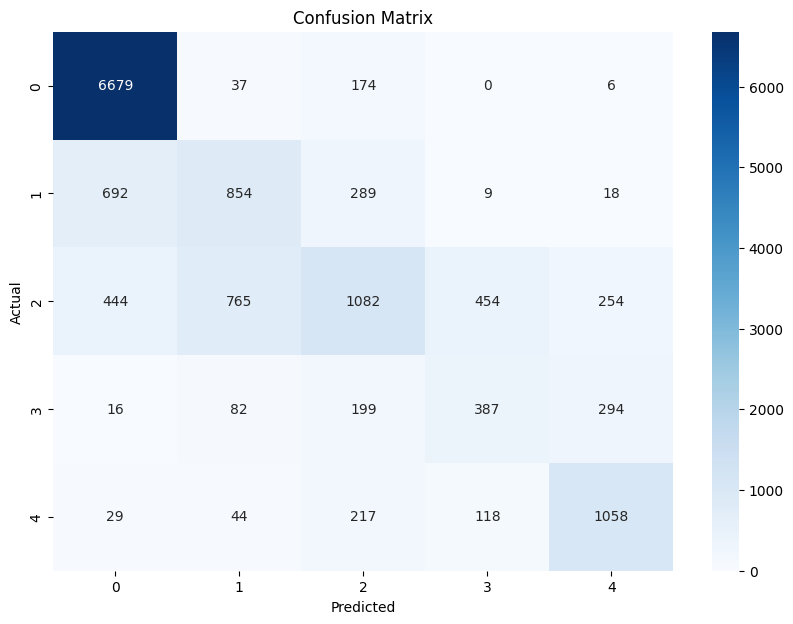

In [16]:
import pandas as pd
# Plot confusion matrix
def plot_confusion_matrix(generator, model):
    y_true = generator.dataset.targets
    model.eval()
    y_pred = []
    with torch.no_grad():
        for inputs, _ in generator:
            inputs = inputs.to(device)  # Move data to GPU
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.tolist())

    cm = confusion_matrix(y_true, y_pred)
    cm_df = pd.DataFrame(cm, index=generator.dataset.classes, columns=generator.dataset.classes)

    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(test_loader, model)

In [17]:
# Function to preprocess the image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img = transform(img)
    img = img.unsqueeze(0)  # Add batch dimension
    return img.to(device)

# Function to predict image class
def predict_image(image_path, model):
    img = preprocess_image(image_path)
    model.eval()
    with torch.no_grad():
        output = model(img)
    _, predicted = torch.max(output, 1)
    return predicted.item()

# Example usage
image_path = '/kaggle/input/eyepacs-aptos-messidor-diabetic-retinopathy/dr_unified_v2/dr_unified_v2/test/2/0415fc68b176.jpg'
predicted_class = predict_image(image_path, model)
print(f'Predicted class: {predicted_class}')

Predicted class: 2


In [22]:
# Function to preprocess the image
def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img = transform(img)
    img = img.unsqueeze(0)  # Add batch dimension
    return img.to(device)

# Function to predict image class
def predict_image(image_path, model):
    img = preprocess_image(image_path)
    model.eval()
    with torch.no_grad():
        output = model(img)
    _, predicted = torch.max(output, 1)
    return predicted.item()

# Example usage
image_path = '/kaggle/input/eyepacs-aptos-messidor-diabetic-retinopathy/dr_unified_v2/dr_unified_v2/test/3/24140_right.jpg'
predicted_class = predict_image(image_path, model)
print(f'Predicted class: {predicted_class}')

Predicted class: 3
